# Chapter 7 - Simulation

In the previous chapter we saw a variety of distributions that can be used for situations that fall into Knight's [_a priori risk_](#frank_knight) category. If we are confident that a known distribution describes all the outcomes and all their associated probabilities, then we might even be able to get a closed-form description of relevant risk metrics.

But in many cases pricing functions for financial instruments are complex. For example, the Nelson-Siegel curve (3.14) is highly nonlinear, and the price (3.2) of a bond based on discount factors obtained from a Nelson-Siegel curve introduces more nonlinearity. So even if we think we have a state of Knightian Risk with respect to the distributions of future parameters of a Nelson-Siegel discount curve, the range of outcomes of rates of return on a portfolio of bonds likely will not have a closed-form solution.

In such cases, **`simulation`** &mdash; often called **`Monte Carlo simulation`** due to the random nature of the casinos in Monte Carlo &mdash; is used. A random number generator is used to pick samples from a distribution of some underlying variables such as the four parameters of the Nelson-Siegel curve. Then, conditional on the future evolving according to the sample draw, the object of interest &mdash; such as a portfolio of bonds discounted by the Nelson-Siegel curve based on the sample parameters &mdash; is valued. The distribution of results &mdash; such as rates of return on the bond portfolio&mdash; is then analyzed for relevant statistics.

We have seen this technique already. The short rate models in sections 3.8.2 through 3.8.4 are examples of simulations; they generate a distribution of yield curves that can be used to value fixed income instruments. The resampled efficient frontier in section 4.2.2 is another example. An efficient portfolio is a highly nonlinear function of inputs such as a mean vector and a covariance matrix. The resampling process is designed to produce an informative distribution of portfolios from which either a range or a center can be chosen.

We can consider these techniques _guided looks into the future_. If our technique is good, then the future that actually does unfold (and futures reasonably like the true one) will be among the outcomes, and their associated probabilities will cause us to plan appropriately.

## 7.1 Historical Simulation

Perhaps the simplest way to generate outcomes and probabilities is **`historical simulation`**. In its purest form, this method requires no model other than the empirical history of the securities in our portfolio.

A slightly more crafted version of historical simulation uses factor models for securities. For example, we may own Facebook (FB) in our portfolio. Facebook common stock was not publicly traded before 2012. We may not consider that Facebook's history is not long enough to build up reliable estimates of its behavior. To address this problem, Facebook could be modeled as a linear combination of (1) an index of large American technology companies; and (2) an index of global social networking firms. Those indices go back in time further than Facebook itself, allowing the factors' empirical histories to fill in missing time periods.

We'll think about a historical simulation involving our familiar Swissie, yen, pound example from section 4.1.2, using data going back to 1971. In particular, suppose we have a portfolio consisting of $w=(1/3, 1/3, 1/3)^{\prime}$ of each of these currencies. Let $T$ be the number of days of history we have. Suppose $X$ is the $T\times3$ matrix whose $(t,i)$ entry is the logarithm of {(dollars per currency i on day t) divided by (dollars per currency i on day t-1)}. Then to do historical simulation, we first form the $T$-vector $r=Xw$.[$^1$](#seven_footnotes)

$r$ is a finite sample space, giving outcomes of log-returns on our portfolio $w$. Observation $r_t$ in the vector $r$ ($t=1,\dots,T$) is assumed to have a probability $p_t$ of being observed. In this context we'll assume that time runs backward so $r_1$ is the most recent observation and $r_T$ is the oldest observation. In the simplest version, the observation distribution is uniform, so $p_t=\frac{1}{T}\enspace\forall t$. 

A variant of this is to weight recent observations more heavily. We might think that going forward, the world will look more like it did last year than it did in 1971. Thus we might use an observation distribution $p_t$ where $p_i\geq p_j$ when $i\leq j$. A common technique is an **`exponentially weighted moving average`**, or **`EWMA`**: the observation probabilities are given by
$$p_t=\frac{2^{-h(t-1)}}{\sum_{s=0}^{T-1}2^{-hs}}=\frac{2^{-h(t-1)}(1-2^{-h})}{1-2^{-hT}}\approx2^{-h(t-1)}(1-2^{-h})\approx2^{-h(t-1)}\frac{h\cdot ln(2)}{1+\frac{h\cdot ln(2)}{2}}\tag{7.1}$$

For example $h=1/252$ would be a one year half-life, since there are about 252 business days in a year. In that case the observations from a year ago would be half as probable as the most recent observation; three years ago would be one eighth as probable.

Whichever probability measure we use, for our 3-currency portfolio the simulation process was particularly easy &mdash; it just consisted of taking a linear combination of inputs. For this simple simulation, much of what we want to know is embodied in the 3-currency mean vector and $3\times3$ covariance matrix. However these quantitites are averages over the decades of data that we used. So even here the simulation process can give more information, for example about what might happen during extreme economic conditions.

A histogram of the outcomes (equally weighted in time) for the 3-currency portfolio (equally weighted by currency) is shown below. The pattern looks familiar:

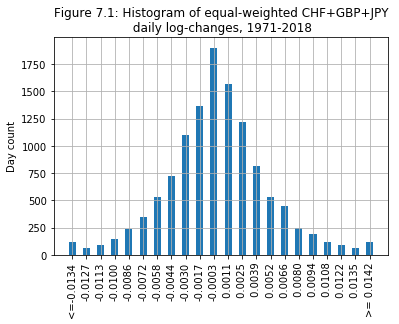

╒════════════════════╤═══════════════╕
│ Statistic          │         Value │
╞════════════════════╪═══════════════╡
│ Count              │ 12036         │
├────────────────────┼───────────────┤
│ Min                │    -0.0420495 │
├────────────────────┼───────────────┤
│ Max                │     0.0498006 │
├────────────────────┼───────────────┤
│ Mean               │     5.52e-05  │
├────────────────────┼───────────────┤
│ Median             │     1.06e-05  │
├────────────────────┼───────────────┤
│ Standard Deviation │     0.0052332 │
├────────────────────┼───────────────┤
│ Skewness           │     0.176957  │
├────────────────────┼───────────────┤
│ Excess Kurtosis    │     4.5103    │
├────────────────────┼───────────────┤
│ Jarque-Bera        │ 10264.7       │
├────────────────────┼───────────────┤
│ Chi-Squared p      │     0         │
├────────────────────┼───────────────┤
│ Serial Correlation │     0.022813  │
├────────────────────┼───────────────┤
│ 99% VaR            │   

In [29]:
%matplotlib inline
import pandas as pd
import qrbook_funcs as qf
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy import stats
#Get 3 currencies until the end of
#previous year. Form sample covariance matrix
#and do simple efficient frontier calculations

lastday=qf.LastYearEnd()
#Swiss franc, pound sterling, Japanese Yen
seriesnames=['DEXSZUS','DEXUSUK','DEXJPUS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)

#Convert levels to log-returns
#First take logs of the currency levels
#Currency exchange rates are usually expressed in the direction
#that will make the rate > 1
#Swissie and yen are in currency/dollar, but
#pounds is in dollar/currency. Reverse signs
#so everything is in dollar/currency

#Do each currency separately to account for separate missing data patterns
#dlgs is a list of lists of length 3 corresponding to the 3 currencies
#The value in dlgs is nan if there is missing data for the present or previous day's observation
#Otherwise it is the log of today/yesterday
multipliers=[-1,1,-1]
dlgs=[]
for i in range(len(multipliers)):
    lgrates=[]
    previous=-1
    for t in range(len(ratematrix)):
        if pd.isna(ratematrix[t][i]) or ratematrix[t][i]<=0:
            lgrates.append(np.nan)    #Append a nan
        else:
            if previous < 0:    #This is the first data point
                lgrates.append(np.nan)
            else:
                lgrates.append(np.log(ratematrix[t][i]/previous)*multipliers[i])
            previous=ratematrix[t][i]
    dlgs.append(lgrates)

#dlgs is the transpose of what we want - flip it
dlgs=np.transpose(dlgs)

#Delete any time periods that don't have data
lgdates=[]
difflgs=[]
for t in range(len(dlgs)):
    if all(pd.notna(dlgs[t])):
        #include this time period
        difflgs.append(dlgs[t])
        lgdates.append(cdates[t])

#Mean vector and covariance matrix are inputs to efficient frontier calculations
d=np.array(difflgs)
m=np.mean(d,axis=0)
c=np.cov(d.T)

#Show histogram of equal-weighted
#CHF-GBP-JPY log-changes
w=np.array([1/3]*3).T
portfolio=np.dot(difflgs,w)
#portfolio now contains the equal-weighted portfolio's
#log-returns. Create buckets - hist function doesn't
#seem to have "x or less" or "x or more" buckets
bucketnames=[]
bucketcounts=[]
#Bucket the end percentiles
low1=np.percentile(portfolio,1)
high1=np.percentile(portfolio,99)
bucketnames.append('<=%7.4f' % low1)
bucketcounts.append(sum(1 for x in portfolio if low1 >= x))
#Count 20 even buckets in between low and high
nbucket=20
bucketwidth=(high1-low1)/nbucket
for i in range(20):
    attach=low1+i*bucketwidth
    detach=attach+bucketwidth
    mid=(attach+detach)/2
    bucketnames.append('%7.4f' % mid)
    bucketcounts.append(sum(1 for x in portfolio if (x>=attach and x<=detach)))

#last bucket
bucketnames.append('>=%7.4f' % high1)
bucketcounts.append(sum(1 for x in portfolio if x >= high1))

width=.5
plt.bar(range(nbucket+2),bucketcounts,width)
plt.xticks(range(nbucket+2),bucketnames,rotation='vertical')
plt.grid()
plt.ylabel('Day count')
plt.title('Figure 7.1: Histogram of equal-weighted CHF+GBP+JPY\n daily log-changes, '+lgdates[0][:4]+'-'+lastday[:4])
plt.show();
    
statnames,metrics,table=qf.StatsTable(portfolio)
headers=['Statistic','Value']
print(tabulate(table, headers, tablefmt='fancy_grid'))

So our very simple look into the future of our equally weighted portfolio of Swissies, pounds and yen tells us that IF we expect the future to be like the 48 years 1971-2018, then
 - A typical daily move will be about $\pm52bps$ (standard deviation = 52bps/day)
 - 99% of the time we will lose less than 1.341% a day (99% VaR=.01341)
 - When we do lose more than that, we’ll lose on average 1.744% (cVaR)
We will be drawing from a normal-looking, but actually fat-tailed, distribution.[$^2$](#seven_footnotes)

As it turns out we would have made a profit &mdash; almost doubling our money over 48 years or about 1.39% a year. However for risk management purposes, quite often we ignore the mean or set it to zero. In many cases empirically (and as we see here), the mean is negligible compared to the volatility. That is usually true over short periods such as a day. Over longer periods such as a year, the mean may not be negligible. That is because the mean scales linearly with time, while standard deviation usually scales as the square root of time.

## 7.2 Delta-Normal
<font color="white">$$\label{eq:factor_practice}\tag{5.40}$$
$$\label{eq:normal_var}\tag{2.8}$$
$$\label{eq:normal_cvar}\tag{2.9}$$
$$\label{eq:three_currency_sampcov}\tag{4.20}$$
</font> 

A second common method for generating future distributions is **`delta-normal`**. This method assumes that input variables &mdash; the three currencies in our 3-currency example &mdash; will follow a multivariate normal distribution. Often the mean of the multivariate normal is assumed to be zero; as we noted above, for short periodicities the mean is usually negligible compared to the higher moments.

The delta-normal method starts by mapping portfolio holdings into the appropriate exposure vector $w$. As with our historical example, this vector may simply be a vector of weights of the securities in the portfolio, with an associated covariance matrix $C$.

For large institutional portfolios, the security-specific variance matrix $D$ in \eqref{eq:factor_practice} is often ignored. This is because in the quadratic form $w^{\prime}Dw$, only the squares of security weights appear. In a large portfolio, it is unlikely that any one security occupies more than a few percent, perhaps even less. Squaring a few percent gets down to basis points. Further, if the factor model is well-specified, the entries of $D$ are small. This is basically the argument that was made in the development of the [Arbitrage Pricing Theory](#arbitrage_pricing).

Thus we may take a vector of security weights $w$ and map it into factor loadings $b=B^{\prime}w$, where $B$ is the factor loading matrix in \eqref{eq:factor_practice}. In that case the associated covariance matrix is the $F$ in \eqref{eq:factor_practice}.

When there are more complex securities such as options, the **`delta`** (first-order sensitivity) of the security to an underlying linear security or factor is added in to the exposure vector. This is what gives rise to the name "delta-normal."

In the delta-normal method, we can form the appropriate statistics directly. Let’s say $e$ is the exposure n-vector (either a security weight vector $w$ or a factor exposure vector $b$), and $M$ is the associated covariance matrix. Then the variance of the distribution of portfolio outcomes is $e^{\prime}Me$ and the standard deviation is $\sigma=\sqrt{e^{\prime}Me}$. The Value at Risk at probability $p$ is $v=-\sigma*Norm^{-1}(p)$ as in \eqref{eq:normal_var} with $\mu=0$. At $p=99%$, that's $2.326\sigma$. The cVaR (= Expected Shortfall since Norm is continuous) (expressed as a loss amount) is
$$\frac{\sigma}{(1-p)\sqrt{2\pi}}\exp\bigl(\frac{-v^2}{2\sigma^2}\bigr)$$
as in \eqref{eq:normal_cvar} with $\mu=0$.

The code in the next cell draws the histogram directly from the multivariate normal distribution, and generates the statistics table under the delta-normal assumption. We've assumed the normal distribution of log-returns has the mean from the historical data so as to make the statistics more directly comparable; in practice as noted we might just assume a zero mean.

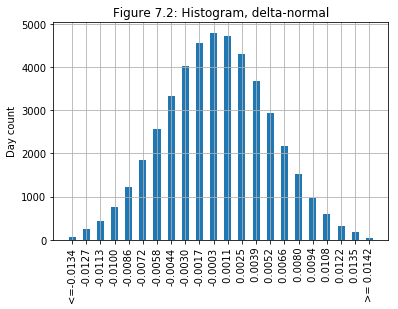

╒════════════════════╤════════════════╕
│ Statistic          │          Value │
╞════════════════════╪════════════════╡
│ Count              │ 12036          │
├────────────────────┼────────────────┤
│ Min                │    -0.0196517  │
├────────────────────┼────────────────┤
│ Max                │     0.0197621  │
├────────────────────┼────────────────┤
│ Mean               │     5.52e-05   │
├────────────────────┼────────────────┤
│ Median             │     1.06e-05   │
├────────────────────┼────────────────┤
│ Standard Deviation │     0.00523341 │
├────────────────────┼────────────────┤
│ Skewness           │     0          │
├────────────────────┼────────────────┤
│ Excess Kurtosis    │     0          │
├────────────────────┼────────────────┤
│ Jarque-Bera        │     0          │
├────────────────────┼────────────────┤
│ Chi-Squared p      │     1          │
├────────────────────┼────────────────┤
│ Serial Correlation │     0          │
├────────────────────┼────────────────┤


In [62]:
# get historical parameters we won't change
count=float(table[0][1])
port_mean=float(table[3][1])
# compute std deviation directly from covariance matrix
port_std=np.sqrt(np.matmul(np.matmul(w,c),w))

#Redo histogram with normal assumption

bucketcounts=[]
#Bucket the end percentiles
bucketcounts.append(stats.norm.cdf((low1-port_mean)/port_std)*count)
for i in range(20):
    attach=low1+i*bucketwidth
    detach=attach+bucketwidth
    mid=(attach+detach)/2
    bucketnames.append('%7.4f' % mid)
    bucketcounts.append(stats.norm.pdf((mid-port_mean)/port_std)*count)

#last bucket
bucketcounts.append((1-stats.norm.cdf((high1-port_mean)/port_std))*count)

width=.5
plt.bar(range(nbucket+2),bucketcounts,width)
plt.xticks(range(nbucket+2),bucketnames,rotation='vertical')
plt.grid()
plt.ylabel('Day count')
plt.title('Figure 7.2: Histogram, delta-normal')
plt.show();

#Delta-normal calculations - redo the stats table
table_norm=table
#min
table_norm[1][1]=str(port_mean+stats.norm.ppf(1/(count+1))*port_std)
#max
table_norm[2][1]=str(port_mean+stats.norm.ppf(count/(count+1))*port_std)
#mean - leave alone
#median - make it equal the mean because normal
table_norm[4][1]=table_norm[4][1]
#standard deviation - use w'Cw
table_norm[5][1]=str(port_std)
#skewness - zero because normal
table_norm[6][1]="0"
#excess kurtosis - zero because normal
table_norm[7][1]="0"
#Jarque-Bera - zero because normal
table_norm[8][1]="0"
#Chi-squared - one because normal
table_norm[9][1]="1"
#Serial correlation - zero by assumption
table_norm[10][1]="0"
#99% VaR - from formula
p=.99
norm_VaR=-(port_mean+stats.norm.ppf(1-p)*port_std)
table_norm[11][1]=str(norm_VaR)
#99% cVar - from formula
norm_cVaR=port_std*np.exp(-.5*(norm_VaR/port_std)**2)
norm_cVaR/=(1-p)*np.sqrt(2*np.pi)
norm_cVaR=-port_mean+norm_cVaR
table_norm[12][1]=str(norm_cVaR)
print(tabulate(table_norm, headers, tablefmt='fancy_grid'))

Figure 7.2 looks generally similar to Figure 7.1, but 7.2 falls off at the tails while 7.1 has extra probability at the two extremes as a result of its leptokurtosis.

Note that the standard deviations of the historical simulation and the delta-normal method agree to four decimal places. Of course that's not a coincidence: if $X$ is the $T\times3$ matrix of daily log-returns of the three currencies, then the covariance matrix in \eqref{eq:three_currency_sampcov} was $C=(X-JX/T)^{\prime}(X-JX/T)/T$ where $J$ is the $T\times T$ matrix of all ones. The delta-normal calculation of standard deviation was $\sigma_{delta-normal}=\sqrt{w^{\prime}Cw}$.

The historical simulation's standard deviation was obtained by forming the $T$-vector $r=(X-JX/T)^{\prime}w$, and then taking its sample standard deviation $\sigma_{historical}=r^{\prime}r/T$. So $\sigma_{delta-normal}=\sigma_{historical}$ to within the precision of the calculation.

While the delta-normal method doesn’t deal with tail risk, it has a great advantage: we can apply the **`Euler rule`**. The Euler rule states that if $f(x)$ is a positive homogeneous and differentiable function of an $n$-vector $x=(x_1,\dots,x_n)$, then
$$z\cdot f(x)=\sum_{i=1}^n x_i \frac{\partial f}{\partial{x_i}}(x)\label{eq:euler_rule}\tag{7.2}$$

We've already discussed positive homogeneity in the context of [coherent risk measures](#coherent_risk) in Chapter 2; here positive homogeneity means that $f(kx)=k^z f(x)$ where $k$ is a positive scaler and $z$ is a scalar. We used $z=1$, but in fact \eqref{eq:euler_rule} works for any complex $z$.

We've know from our discussion of [coherent risk measures](#coherent_risk) that standard deviation ($\sqrt{w^{\prime} Cw}$) is positive homogenous with $z=1$. That allows us to decompose delta-normal standard deviation into the influences of each component:
$$\sigma(w)=\sqrt{w^{\prime}Cw}\text{; }\frac{\partial \sigma}{\partial w}=g=\frac{1}{\sigma}Cw\text{; }\sigma(w)=w^{\prime}g\label{eq:euler_std}\tag{7.3}$$
Here $g$ is the **`gradient vector`**. The right-hand side of \eqref{eq:euler_std} is a vector dot product – the vector version of the Euler decomposition in \eqref{eq:euler_rule}. The $i^{th}$ summand ($i=1$ to $n$) in the dot product is the contribution of the $i^{th}$ element to the overall delta-normal standard deviation.

Computing these quantities for the 3-currency example, we obtain the following:

In [64]:
#Compute gradient
port_gradient=np.matmul(c,w)/port_std
print('Gradient (bps/day):',port_gradient)
print('Contributions to Std Dev:',port_gradient*w)

Gradient (bps/day): [0.00630252 0.00460355 0.00479415]
Contributions to Std Dev: [0.00210084 0.00153452 0.00159805]


From this we can see that the Swissie is the biggest contributer to standard deviation. If we think that one of the other currencies is going to outperform Swissies, we could shift some weight from the Swissie to that currency and have a win-win situation: increasing expected return while lowering expected risk.

This helps to make risk/reward decisions. In more complex covariance matrices, we can even have some items with a negative contribution to overall standard deviation; those are diversifiers. If we think that a diversifier is going to generate more return than other items, then we can increase the exposure to the diversifier and get more return while reducing risk.

## Chapter 7 Footnotes
<a name="seven_footnotes"></a>
<br>
$^1$ To generate the log-returns of the portfolio, we would actually need to convert the log-returns of the components back to returns, take the weighted combination, and convert back to log-returns. For short time periods like a day there isn't much difference between log-returns and returns so we'll use this simple form.

<br>
$^2$ As in the previous footnote, we haven't back-transformed our log-returns into rates of return, so the cited statistics are actually referencing the historical log-returns distribution.